<a href="https://colab.research.google.com/github/anosharahim/capstone/blob/master/fer_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [66]:
#for preprocessing
import pandas as pd
import os
import imageio
import numpy as np
import random 

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#machine learning specific 
import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#get GPU
#K.tensorflow_backend._get_available_gpus()

In [47]:
#Load train and test data

train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

print('Train Size: ', x_train.shape, y_train.shape)
print('Test Size: ',x_test.shape, y_test.shape)

Train Size:  (28709, 48, 48) (28709,)
Test Size:  (7178, 48, 48) (7178,)


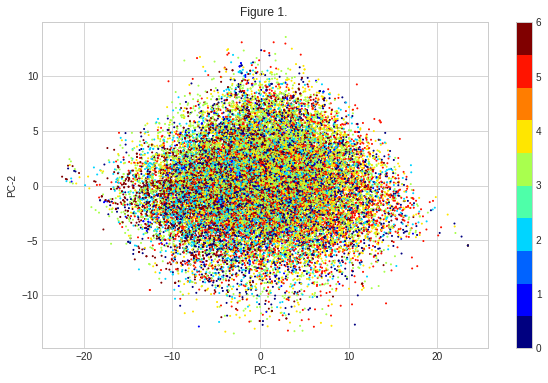

In [75]:
t = x_train.reshape(len(x_train),48*48)
t.shape

scaler = MinMaxScaler()
train_rescaled = scaler.fit_transform(x_train.reshape(len(x_train),48*48))
#Two-Component PCA
pca_ = PCA(n_components=2)
pca_ = pca_.fit_transform(train_rescaled)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)

plt.scatter(pca_[:, 0], pca_[:, 1], s = 1, cmap = c_map , c = y_train) 
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.title('Figure 1. ')
plt.show()

In [76]:
#Three-Component PCA
pca_3d = PCA(n_components=3)
pca_3d = pca_3d.fit_transform(train_rescaled)

#plot 3 components 

def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=2,
            color=x_train,      # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_white'
    fig.show()

plt.ioff()
plot_3d(pca_3d[:, 0],pca_3d[:, 1],pca_3d[:, 2])

In [ ]:
tsne = TSNE(learning_rate=2)
TSNE_features = tsne.fit_transform(pca_3d)
a = TSNE_features[:,0]
b = TSNE_features[:,1]
sns.scatterplot(a,b,hue=y_train, legend='full',s=10, palette = 'bright')#, hue=y, legend='full')
sns.set(rc={'figure.figsize':(20,18)})

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_rescaled)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in train_label], s= 2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of FER2013 dataset', fontsize=24)